# 1. Setup

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow  opencv-python matplotlib

In [2]:
import tensorflow as tf

## 1.2 Import Dependencies

In [56]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [57]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [58]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [13]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf data/anchor/archive/lfw-funneled.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [15]:
# Import uuid library to generate unique image names
import uuid

In [16]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\ea111753-09f8-11f0-ac38-60f26206a526.jpg'

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [28]:
import os
import glob

jpg_files = glob.glob(os.path.join(POS_PATH, '**', '*.jpg'), recursive=True)
print(len(jpg_files))


2380


In [15]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [16]:
import os
import uuid

In [18]:
img_path = os.path.join(ANC_PATH, '0e17dfcd-09f9-11f0-9e10-60f26206a526.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
import os
import glob

jpg_files = glob.glob(os.path.join(ANC_PATH, '**', '*.jpg'), recursive=True)
print(len(jpg_files))


# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [59]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(2000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(2000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(2000)

In [60]:
dir_test = anchor.as_numpy_iterator()

In [61]:
print(dir_test.next())

b'data\\anchor\\8bde89af-09f9-11f0-913c-60f26206a526.jpg'


## 3.2 Preprocessing - Scale and Resize

In [62]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [63]:
img = preprocess('data/anchor/0e17dfcd-09f9-11f0-9e10-60f26206a526.jpg')

In [64]:
img.numpy().max() 

np.float32(1.0)

In [ ]:
dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [179]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [65]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [66]:
positives = tf.data.Dataset.zip((
    anchor, 
    positive, 
    tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor), dtype=tf.float32)).map(lambda x: tf.cast(x, tf.float32))  # Ensure Python float-like behavior
))
negatives = tf.data.Dataset.zip((
    anchor, 
    negative, 
    tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor), dtype=tf.float32)).map(lambda x: tf.cast(x, tf.float32))  # Ensure Python float-like behavior
))
data = positives.concatenate(negatives)
  # Output: (b'path_to_anchor', b'path_to_positive', 1.0)


In [67]:
samples = data.as_numpy_iterator()

In [68]:
exampple = samples.next()

In [69]:
exampple

(b'data\\anchor\\75ee96ea-09fa-11f0-8fa2-60f26206a526.jpg',
 b'data\\positive\\218f0563-7f4f-11f0-b6ae-98e743a530ec.jpg',
 np.float32(1.0))

## 3.4 Build Train and Test Partition

In [70]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [71]:
res = preprocess_twin(*exampple)

In [73]:
len(res)

3

In [74]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [75]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [76]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [77]:
inp = Input(shape=(100,100,3), name='input_image')

In [78]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [79]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [80]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [81]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [82]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [83]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [84]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [85]:
embedding = make_embedding()

In [86]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [87]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [88]:
l1 = L1Dist()

In [89]:
l1

<L1Dist name=l1_dist, built=False>

In [90]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model

# Define the embedding model
def make_embedding(): 
    inp = Input(shape=(100, 100, 3))
    
    # CNN blocks
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=inp, outputs=d1)

# Create the embedding model
embedding = make_embedding()

# Siamese L1 Distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Instantiate L1 Distance layer
l1 = L1Dist()

# Create dummy images for testing
dummy_anchor = tf.random.normal((1, 100, 100, 3))  # Single image
dummy_validation = tf.random.normal((1, 100, 100, 3))  # Single image

# Pass images through the embedding model
anchor_embedding = embedding(dummy_anchor)
validation_embedding = embedding(dummy_validation)

# **Manually build the L1Dist layer**
l1.build((None, 4096))  # Specify expected input shape

# Compute L1 Distance
distance = l1(anchor_embedding, validation_embedding)
print(distance)  # Output: Tensor containing absolute difference


tf.Tensor([[0.02125961 0.01094204 0.02472436 ... 0.00284699 0.0052368  0.0094642 ]], shape=(1, 4096), dtype=float32)


## 4.3 Make Siamese Model

In [91]:
l1

<L1Dist name=l1_dist_1, built=True>

In [92]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [93]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [94]:
siamese_layer = L1Dist()

In [95]:
distances = siamese_layer(inp_embedding, val_embedding)

In [96]:
classifier = Dense(1, activation='sigmoid')(distances)

In [97]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_40>

In [98]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [99]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ functional[0][0],          │
│                               │                           │                 │ functional[1][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [101]:
siamese_model = make_siamese_model()

In [102]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (None, 4096)              │               0 │ functional[2][0],          │
│                               │                           │                 │ functional[3][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [103]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [104]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [105]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [106]:
test_batch = train_data.as_numpy_iterator()

In [107]:
batch_1 = test_batch.next()

In [108]:
X = batch_1[:2]

In [109]:
y = batch_1[2]

In [110]:
y

array([0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

In [ ]:
tf.losses.BinaryCrossentropy??

In [112]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [113]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [114]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))  # Set total steps

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model(batch[:2], training=False)
            
            # Update metrics
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)

            progbar.update(idx + 1)  # Update progress bar

        # Print final loss and metrics for the epoch
        print(f"Loss: {loss.numpy():.4f} | Recall: {r.result().numpy():.4f} | Precision: {p.result().numpy():.4f}")

        # Save model checkpoint every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


## 5.5 Train the model

In [115]:
batch_1

(array([[[[0.5647059 , 0.6259804 , 0.6227941 ],
          [0.56985295, 0.62941176, 0.6156863 ],
          [0.5720588 , 0.6308824 , 0.6112745 ],
          ...,
          [0.6068627 , 0.6460784 , 0.64215684],
          [0.6137255 , 0.65      , 0.6460784 ],
          [0.6313726 , 0.6666667 , 0.6627451 ]],
 
         [[0.5776961 , 0.62107843, 0.61495095],
          [0.5830882 , 0.6272059 , 0.61838233],
          [0.5830882 , 0.6254902 , 0.6105392 ],
          ...,
          [0.6002451 , 0.6455882 , 0.6365196 ],
          [0.6107843 , 0.6509804 , 0.64411765],
          [0.62058824, 0.6578431 , 0.6509804 ]],
 
         [[0.5852941 , 0.62058824, 0.6166667 ],
          [0.5745098 , 0.6098039 , 0.60539216],
          [0.5762255 , 0.61151963, 0.60563725],
          ...,
          [0.6002451 , 0.64705884, 0.6313726 ],
          [0.6166667 , 0.6605392 , 0.64485294],
          [0.6245098 , 0.66764706, 0.6519608 ]],
 
         ...,
 
         [[0.7147059 , 0.6990196 , 0.69509804],
          [0.71764

In [116]:
batch_1 = test_batch.next()


In [117]:
test_batch = train_data.as_numpy_iterator()


In [118]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings


In [119]:
EPOCHS = 5

In [120]:
train(train_data, EPOCHS)


 Epoch 1/5
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
175/175 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step
Loss: 0.0423 | Recall: 0.9797 | Precision: 0.9956

 Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step
Loss: 0.0304 | Recall: 0.9979 | Precision: 0.9972

 Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step
Loss: 0.0000 | Recall: 0.9993 | Precision: 0.9993

 Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step
Loss: 0.0350 | Recall: 0.9929 | Precision: 0.9887

 Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step
Loss: 0.0002 | Recall: 0.9993 | Precision: 0.9993


# 6. Evaluate Model

## 6.1 Import Metrics

In [121]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [180]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [181]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


In [182]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]

In [183]:
y_true

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [126]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [127]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [128]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model([test_input, test_val], training=False)  # FIXED
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())  # Clean output



1.0 1.0


## 6.4 Viz Results

In [ ]:
pip install scikit-image


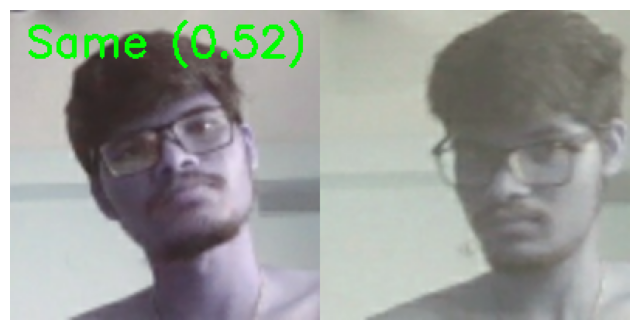

In [163]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def calculate_similarity(img1, img2):
    gray1 = cv2.cvtColor((img1 * 255).astype("uint8"), cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor((img2 * 255).astype("uint8"), cv2.COLOR_RGB2GRAY)
    gray1 = cv2.resize(gray1, (200, 200))
    gray2 = cv2.resize(gray2, (200, 200))
    score, _ = ssim(gray1, gray2, full=True, data_range=255)
    return score

def visualize_result(img1, img2, threshold=0.5):
    similarity = calculate_similarity(img1, img2)

    # Resize for display
    img1 = cv2.resize((img1 * 255).astype("uint8"), (200, 200))
    img2 = cv2.resize((img2 * 255).astype("uint8"), (200, 200))

    combined = np.hstack([img1, img2])

    # Decision
    if similarity >= threshold:
        label = f"Same ({similarity:.2f})"
        color = (0, 255, 0)
    else:
        label = f" Different ({similarity:.2f})"
        color = (255, 0, 0)

    cv2.putText(combined, label, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    return combined

plt.figure(figsize=(8,6))
result = visualize_result(test_input[5], test_val[5], threshold=0.5)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


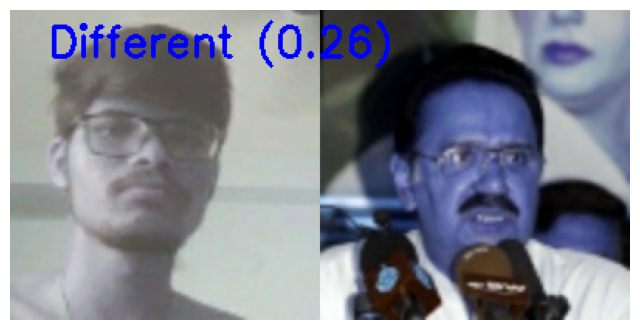

In [147]:
plt.figure(figsize=(8,6))
result = visualize_result(test_input[7], test_val[7], threshold=0.5)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


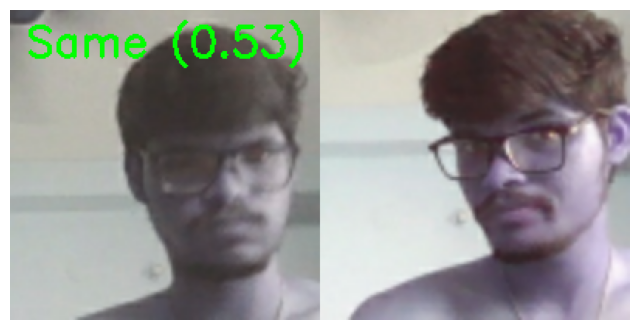

In [185]:
plt.figure(figsize=(8,6))
result = visualize_result(test_input[1], test_val[1], threshold=0.5)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


# 7. Save Model

In [164]:
# Save weights
siamese_model.save('siamesemodelv3.h5')

In [165]:
L1Dist

__main__.L1Dist

In [166]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv3.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [186]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


array([[1.0000000e+00],
       [9.6388400e-01],
       [4.4809447e-08],
       [9.5501697e-08],
       [2.2044830e-07],
       [2.8568289e-07],
       [9.9987525e-01],
       [9.8958147e-01],
       [9.9997634e-01],
       [1.0000000e+00],
       [9.9986500e-01],
       [1.4314265e-05],
       [4.5497527e-06],
       [9.9999428e-01],
       [1.6804253e-07],
       [3.5572214e-08]], dtype=float32)

# 8.PREDICITION AFTER LOADING

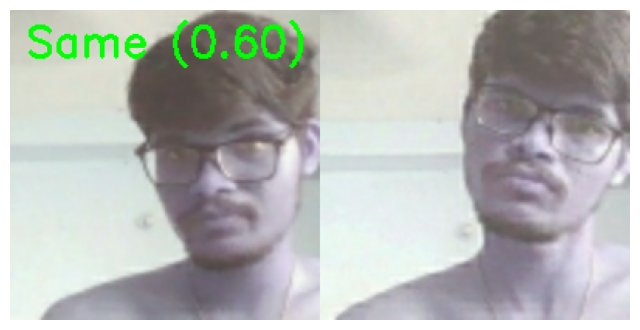

In [187]:
plt.figure(figsize=(8,6))
result = visualize_result(test_input[7], test_val[7], threshold=0.5)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [168]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_4 (L1Dist)            │ (None, 4096)              │               0 │ functional[0][0],          │
│                               │                           │                 │ functional[1][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_4[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)